# Example - Normal Estimation

The following cell imports the resources needed for basic geometry processing and 3D visualisation. Few resources are referenced to test the implemented algorithm.

In [3]:
import sys,os

# Path to Resources and Python Libraries
RES_PATH = '../../resources'
LIB_PATH = '../../python_lib'

# Checking if the path is found locally
if not os.path.exists(RES_PATH):
    print( 'cannot find \COMPM080-Tutorials-2020\resources\, please update RES_PATH')
    exit(1)
else:
    print('found resources')

# Loading Geo Tools
sys.path.append(LIB_PATH) 
from geo_tools import rd_helper

# Loading libraries for visualisation
import pyglet
pyglet.options['shadow_window'] = False
import pyrender
import matplotlib
import matplotlib.pyplot as plt

# Loading libraries for basic geometry processing
import trimesh
import numpy as np
from sklearn.neighbors import KDTree

found resources


d:\Anaconda\envs\geo_tutorials\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


We load the mesh of a torus and sample 30000 points on the surface of the loaded mesh.

In [4]:
# Loading the mesh
mesh_fp = os.path.join(RES_PATH,'torus.obj')
assert os.path.exists(mesh_fp), 'Cannot find:' + mesh_fp 
mm = trimesh.load(mesh_fp)
# Sampling points on the surface of the mesh - looks better with more points, but can be slow
surface_points = mm.sample(3000)
print(surface_points.shape)

(3000, 3)


We can visualise the 3D point cloud sampled in the previous cell.

d:\Anaconda\envs\geo_tutorials\lib\site-packages\matplotlib\collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


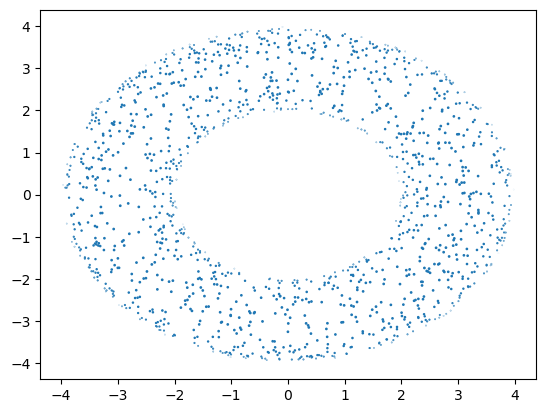

In [5]:
plt.scatter(surface_points[:,0],surface_points[:,1],surface_points[:,2])

# Least square based Normal Estimation

The following cell implements the least square plane fitting for normal estimation.

In [20]:
import numpy.linalg as la

def lstsq_plane_fitting(surface_points, k):
    ### fill in this function. normals should have same dimension as surface_points (nx3)
    ### k is the number of neighbours
    
    normals = np.zeros((surface_points.shape[0], 3)) ### (change this)
    tree = KDTree(surface_points)
    neighbor_idx = tree.query(surface_points, k=k, return_distance=False)
    for i in range(surface_points.shape[0]):
        this_neighbor = surface_points[neighbor_idx[i],:]
        d = np.linalg.norm(surface_points[i])
        normal = np.linalg.pinv(this_neighbor) @ np.full((this_neighbor.shape[0]), d)
        normal /= np.linalg.norm(normal)
        normals[i] = normal
    return normals

In [21]:
normals = lstsq_plane_fitting(surface_points, 4)

We add a function that helps for visualisation purpose to render the point normals.

In [22]:
def create_vertex_normal_render_obj(surface_points, normals):
    p0 = surface_points
    p1 = surface_points + normals
    edges_mesh = rd_helper.create_edges(p0,p1,no_vex=True)
    return edges_mesh

We can create the scene witht the mesh and the point normals.

In [23]:
# Creation of the objects to render
mobj = pyrender.Mesh.from_trimesh(mm)
vobj = create_vertex_normal_render_obj(surface_points, normals)

# Adding the objects into the scene graph

scene = pyrender.Scene(ambient_light=0.4*np.array([1.0, 1.0, 1.0, 1.0]))
mesh_node = scene.add(mobj)
if vobj is not None:
    nv_node = scene.add(vobj)

# Initialisation of the context object
gctx={}
gctx['nv_node'] = nv_node
gctx['show_mesh_node'] = True
gctx['show_nv_node'] = True
gctx['scene'] = scene
gctx['cur_scale'] = 1.0
gctx['cur_color'] = np.array((0,255,0), dtype=np.uint8)

In [25]:
def run_gui(scene):        
    v = pyrender.Viewer(scene, use_raymond_lighting=True)
    del v

    
run_gui(scene)

# PCA based normal estimation

The following cell implements the least square plane fitting for normal estimation.

In [78]:
def PCA_normal_estimation(surface_points, k):
    ### fill in this function. normals should have same dimension as surface_points (nx3)
    ### k is the number of neighbours

    normals = np.zeros((surface_points.shape[0], 3)) ### (change this) 
    tree = KDTree(surface_points)
    neighbor_idx = tree.query(surface_points, k=k, return_distance=False)
    for i in range(surface_points.shape[0]):
        this_neighbor = surface_points[neighbor_idx[i]]
        mean = np.mean(this_neighbor, axis=0)
        cov = (this_neighbor-mean).T @ (this_neighbor-mean) / (k-1)
        U, S, Vh = np.linalg.svd(cov)
        # we want normal so smallest eigenvalue
        normals[i] = (np.sign(S)*Vh)[-1]
        # print("S: ", S)
        # print(normals[i])
        eigenvalues, eigenvectors = np.linalg.eig(cov)
        # print("ev, ev: ", eigenvalues, eigenvectors)
        sorted_values = np.argsort(-eigenvalues)
        eigenvalues = eigenvalues[sorted_values]
        eigenvectors = eigenvectors[:,sorted_values]
        normal = eigenvectors[:,2]
        nn = np.linalg.norm(normal)
        normal = normal / nn
        normals[i] = normal
    return normals

In [79]:
normals = PCA_normal_estimation(surface_points, 20)

In [80]:
# Creation of the objects to render
mobj = pyrender.Mesh.from_trimesh(mm)
vobj = create_vertex_normal_render_obj(surface_points, normals)

# Adding the objects into the scene graph
scene = pyrender.Scene(ambient_light=0.4*np.array([1.0, 1.0, 1.0, 1.0]))
mesh_node = scene.add(mobj)
if vobj is not None:
    nv_node = scene.add(vobj)

# Initialisation of the context object
gctx={}
gctx['nv_node'] = nv_node
gctx['show_mesh_node'] = True
gctx['show_nv_node'] = True
gctx['scene'] = scene
gctx['cur_scale'] = 1.0
gctx['cur_color'] = np.array((0,255,0), dtype=np.uint8)

In [81]:
def run_gui(scene):    
    v = pyrender.Viewer(scene, use_raymond_lighting=True)
    del v
run_gui(scene)

To Colour Based On Normals

In [82]:
pcd_rdobj = pyrender.Mesh.from_points(surface_points, colors=np.abs(normals) ) ### abs makes sure that the RGB values are between 0 and 1.

In [83]:
def scene_factory(rdobj):
    scene = pyrender.Scene(ambient_light=0.5*np.array([1.0, 1.0, 1.0, 1.0]))
    pcd_nd = scene.add(rdobj)
    
    return scene


def run_gui(rdobj):
    scene = scene_factory(rdobj)
    v=pyrender.Viewer(scene, use_raymond_lighting=True)
    del v


## Run visualisation
### to see it well, you might need to increase number of sampled points.
run_gui(pcd_rdobj)